# <font style="color:blue">Project 3: Object Detection</font>


#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Plot Ground Truth Bounding Boxes</h3></td> <td><h3>20</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Training</h3></td> <td><h3>25</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Inference</h3></td> <td><h3>15</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>COCO Detection Evaluation</h3></td> <td><h3>25</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Run Inference on a Video</h3></td> <td><h3>15</h3></td> </tr>
    </table>
</div>


In [ ]:
# for kaggle env
# !pip install ultralytics

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from dataclasses import dataclass
import os
import math
import shutil
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary as torch_summary
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from ultralytics import YOLO
import wandb
import time
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [2]:
@dataclass
class Config:
    train_images_folder: str
    train_labels_folder: str
    val_images_folder: str
    val_labels_folder: str
    train_csv: str
    val_csv: str
    yolo_config_yaml: str
    training_output_folder: str
    saved_weights_filepath: str
    video_input_filepath: str
    video_output_filepath: str
    device: str

    # noinspection PyAttributeOutsideInit
    def init(self, training):
        self.training = training
        if self.training:
            os.makedirs(self.training_output_folder, exist_ok=True)

        self.seed = 8675309
        self.batch_size = 32
        self.starting_learning_rate = 3e-4
        self.max_epochs = 200
        self.patience = 8
        self.num_workers = 8 if self.device == 'cuda' else 0
        self.pin_memory = self.num_workers > 0
        self.image_size = 640
        self.use_amp = self.device == 'cuda'
        self.verbose = False

        if self.val_csv != 'N/A':
            self.val_ids = pd.read_csv(self.val_csv)['id'].to_numpy()

        self.imagenet_mean_cpu_tensor = torch.tensor(imagenet_mean_array)
        self.imagenet_std_cpu_tensor = torch.tensor(imagenet_std_array)
        self.channelwise_imagenet_mean_cpu_tensor = self.imagenet_mean_cpu_tensor.view(3, 1, 1)
        self.channelwise_imagenet_std_cpu_tensor = self.imagenet_std_cpu_tensor.view(3, 1, 1)
        self.imagenet_mean_gpu_tensor = gpu_tensor(imagenet_mean_array)
        self.imagenet_std_gpu_tensor = gpu_tensor(imagenet_std_array)
        self.channelwise_imagenet_mean_gpu_tensor = self.imagenet_mean_gpu_tensor.view(3, 1, 1)
        self.channelwise_imagenet_std_gpu_tensor = self.imagenet_std_gpu_tensor.view(3, 1, 1)

        self.model_name = 'yolo26s.pt'


config: Config = None
""" Set to environment-relevant config before training/inference """;

In [3]:
local_config = Config(
    train_images_folder='data/license_plates/images/train/',
    train_labels_folder='data/license_plates/labels/train/',
    val_images_folder='data/license_plates/images/val/',
    val_labels_folder='data/license_plates/labels/val/',
    train_csv='data/train.csv',
    val_csv='data/val.csv',
    yolo_config_yaml='data/license_plates.yaml',
    training_output_folder='data_gen/',
    saved_weights_filepath='data_gen/best.pt',
    video_input_filepath='data/license_plate_video.mp4',
    video_output_filepath='data_gen/license_plate_video_inference.mp4',
    device='cpu',
)
kaggle_config = Config(
    train_images_folder='N/A',
    train_labels_folder='N/A',
    val_images_folder='/kaggle/input/datasets/kyledunne/license-plates-dataset/data/license_plates/images/val/',
    val_labels_folder='/kaggle/input/datasets/kyledunne/license-plates-dataset/data/license_plates/labels/val/',
    train_csv='N/A',
    val_csv='N/A',
    yolo_config_yaml='/kaggle/input/datasets/kyledunne/license-plates-kaggle-yaml/license_plates_kaggle.yaml',
    training_output_folder='/kaggle/working/',
    saved_weights_filepath='/kaggle/input/datasets/kyledunne/license-plates-yolo-best-weights-sanity-1/best.pt',
    video_input_filepath='/kaggle/input/license_plate_input_video/license_plate_input_video.mp4',
    video_output_filepath='/kaggle/working/license_plate_video_inference.mp4',
    device='cuda',
)

In [4]:
imagenet_mean_tuple = (0.485, 0.456, 0.406)
imagenet_std_tuple = (0.229, 0.224, 0.225)
imagenet_mean_array = np.array([0.485, 0.456, 0.406], dtype=np.float32)
imagenet_std_array = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def gpu_tensor(numpy_array):
    return torch.tensor(numpy_array, device=config.device)

def gpu_image_tensor_to_numpy_array(image_tensor):
    image = denormalize(image_tensor, config.channelwise_imagenet_mean_gpu_tensor, config.channelwise_imagenet_std_gpu_tensor)
    image = torch.clamp(image, 0, 1)
    image = image.permute(1, 2, 0).cpu().numpy()
    return (image * 255).astype(np.uint8)

def normalize(tensor, mean, std):
    return (tensor - mean) / std

def denormalize(tensor, mean, std):
    return tensor * std + mean

def print_model_torchinfo(model: nn.Module):
    print(torch_summary(model, input_size=(1, 3, config.image_width, config.image_height)))

def print_model(model: nn.Module):
    for name, module in model.named_modules():
        print(name, "->", module.__class__.__name__)

def create_dataloader(dataset, shuffle):
    return DataLoader(dataset, batch_size=config.batch_size, shuffle=shuffle, num_workers=config.num_workers, pin_memory=config.pin_memory, generator=config.generator)

def _num_batches(dataloader):
    return math.ceil(len(dataloader.dataset) / config.batch_size)

In [5]:
config = local_config
config.init(training=False)

# <font style="color:purple">Download the Dataset</font> 

**[Download the Vehicle registration plate](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1)**


Download the Vehicle Registration Plate dataset from [here](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1) and unzip it. 

We will have the following directory structure:

```
Dataset
├── train
│   └── Vehicle registration plate
│       └── Label
└── validation
    └── Vehicle registration plate
        └── Label
```

Unzipping the file will give you a directory `Dataset`. This directory has two folder `train` and `validation`. Each train and validation folder has `Vehicle registration plate`  folder with `.jpg` images and a folder `Labels`.  `Labels` folder has bounding box data for the images.


For example,
For image: `Dataset/train/Vehicle registration plate/bf4689922cdfd532.jpg`
Label file is  `Dataset/train/Vehicle registration plate/Label/bf4689922cdfd532.txt`

There are one or more lines in each `.txt` file. Each line represents one bounding box.
For example,
```
Vehicle registration plate 385.28 445.15 618.24 514.225
Vehicle registration plate 839.68 266.066462 874.24 289.091462
```

We have a single class detection (`Vehicle registration plate detection`) problem. So bounding box details start from the fourth column in each row.

Representation is in `xmin`, `ymin`, `xmax`, and `ymax` format.

**It has `5308` training and `386` validation dataset.**

Data is downloaded from [Open Images Dataset](https://storage.googleapis.com/openimages/web/index.html)

#  <font style="color:green">1. Plot Ground Truth Bounding Boxes [20 Points]</font> 

**You have to show three images from validation data with the bounding boxes.**

The plotted images should be similar to the following:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g1.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g2.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g3.png'>



In [6]:
def plot_images_with_bounding_boxes(images, pred_bounding_boxes=None, pred_boxes_confidence=None, true_bounding_boxes=None):
    for i, image in enumerate(images):
        h, w = image.shape[:2]
        fig, ax = plt.subplots(1)
        ax.imshow(image)
        ax.axis('off')

        if true_bounding_boxes is not None:
            for x_center, y_center, bw, bh in true_bounding_boxes[i]:
                x0 = (x_center - bw / 2) * w
                y0 = (y_center - bh / 2) * h
                rect = patches.Rectangle((x0, y0), bw * w, bh * h,
                                         linewidth=1, edgecolor='orange', facecolor='none')
                ax.add_patch(rect)

        if pred_bounding_boxes is not None:
            for j, (x_center, y_center, bw, bh) in enumerate(pred_bounding_boxes[i]):
                x0 = (x_center - bw / 2) * w
                y0 = (y_center - bh / 2) * h
                rect = patches.Rectangle((x0, y0), bw * w, bh * h,
                                         linewidth=1, edgecolor='blue', facecolor='none')
                ax.add_patch(rect)
                if pred_boxes_confidence is not None:
                    label = f"{int(pred_boxes_confidence[i][j] * 100)}%"
                    ax.text(x0, y0, label, color='blue', fontsize=8,
                            va='bottom', ha='left',
                            bbox=dict(facecolor='white', edgecolor='none', pad=2))

        plt.tight_layout()
        plt.show()

In [7]:
def plot_val_images_with_ground_truth_bounding_boxes(num_images_to_show=3):
    ids = np.random.choice(config.val_ids, num_images_to_show)
    images = []
    all_boxes = []
    for image_id in ids:
        image_path = f'{config.val_images_folder}{image_id}.jpg'
        image_label = f'{config.val_labels_folder}{image_id}.txt'
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        images.append(image)
        boxes = []
        with open(image_label, 'r') as label_file:
            for line in label_file:
                coords = [float(c) for c in line.strip().split()[-4:]]
                boxes.append(coords)
        all_boxes.append(boxes)
    plot_images_with_bounding_boxes(images, true_bounding_boxes=all_boxes)

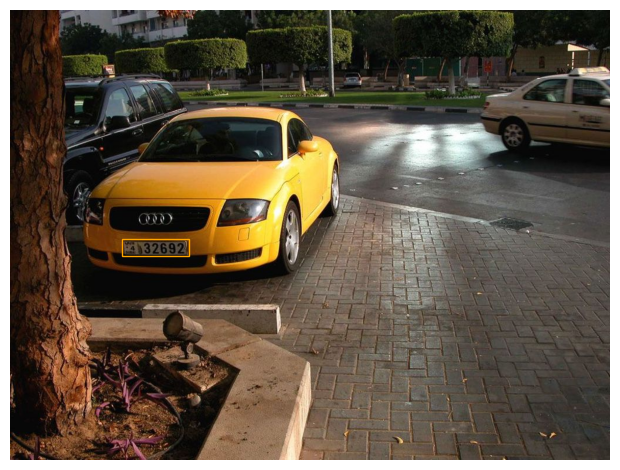

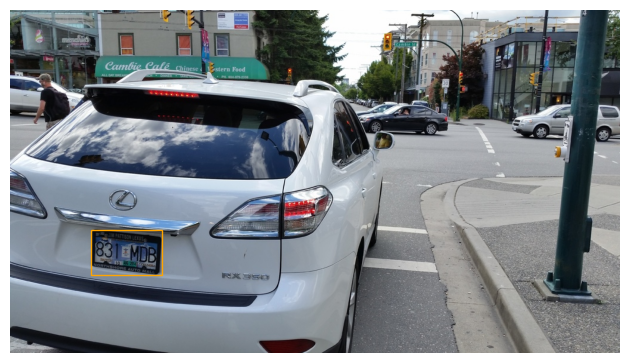

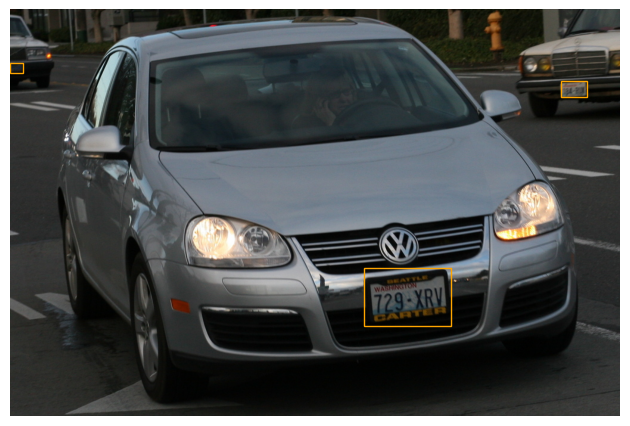

In [8]:
plot_val_images_with_ground_truth_bounding_boxes()

#  <font style="color:green">2. Training [25 Points]</font> 

- **Write your training code in this section.**

- **You also have to share ([shared logs example](https://tensorboard.dev/experiment/JRtnsKbwTaq1ow6nPLPGeg)) the loss plot of your training using tensorboard.dev.** 

How to share TensorBoard logs using tensorboard.dev find [here](https://courses.opencv.org/courses/course-v1:OpenCV+OpenCV-106+2019_T1/courseware/b1c43ffe765246658e537109e188addb/d62572ec8bd344db9aeae81235ede618/4?activate_block_id=block-v1%3AOpenCV%2BOpenCV-106%2B2019_T1%2Btype%40vertical%2Bblock%40398b46ddcd5c465fa52cb4d572ba3229).

In [ ]:
def train_yolo():
    start_time = time.time()
    print(f't=0: Initializing training setup...')

    # Initialize wandb run (logs hyperparams and enables automatic metric logging)
    wandb.init(
        project="license-plate-detection",
        name=f'run={int(start_time)}',
        config={
            "model": config.model_name,
            "epochs": config.max_epochs,
            "batch_size": config.batch_size,
            "image_size": config.image_size,
            "lr0": config.starting_learning_rate,
            "patience": config.patience,
            "seed": config.seed,
            "amp": config.use_amp,
            "device": config.device,
        }
    )

    model = YOLO(config.model_name)

    # Train — verbose=True enables per-epoch cell output logging
    results = model.train(
        data=config.yolo_config_yaml,
        epochs=config.max_epochs,
        imgsz=config.image_size,
        batch=config.batch_size,
        optimizer='AdamW',
        lr0=config.starting_learning_rate,
        warmup_bias_lr=0.01,
        cos_lr=True,
        patience=config.patience,
        seed=config.seed,
        amp=config.use_amp,
        workers=config.num_workers,
        device=config.device,
        verbose=True,
        plots=True,
    )

    # Copy best model weights to config.training_output_folder
    best_src = Path(results.save_dir) / 'weights' / 'best.pt'
    os.makedirs(config.training_output_folder, exist_ok=True)
    best_dst = Path(config.training_output_folder) / 'best.pt'
    shutil.copy(str(best_src), str(best_dst))
    print(f'Best model saved to: {best_dst}')

    # Upload best model to wandb as an artifact (replaces add_wandb_callback checkpointing,
    # which is broken in kaggle environment due to unresolved imports in the callback module)
    artifact = wandb.Artifact(name='best-model', type='model')
    artifact.add_file(str(best_dst))
    wandb.log_artifact(artifact)

    wandb.finish()
    return results

WandB logs:
https://wandb.ai/kyledunne-n-a/license-plate-detection/runs/ayzq4dpm

#  <font style="color:green">3. Inference [15 Points]</font> 

**You have to make predictions from your trained model on three images from the validation dataset.**

The plotted images should be similar to the following:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p1.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p2.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p3.png'>




In [9]:
def predict_yolo(return_preds=True, print_coco_metrics=False):
    model = YOLO(config.saved_weights_filepath)

    # Run validation — logs all available COCO metrics to stdout.
    # save_json=True saves predictions.json to val_results.save_dir, which is read
    # by print_all_coco_metrics() to compute all 12 standard COCO metrics.
    # verbose=True prints the per-class mAP table from ultralytics.
    val_results = model.val(
        data=config.yolo_config_yaml,
        imgsz=config.image_size,
        batch=config.batch_size,
        workers=config.num_workers,
        device=config.device,
        verbose=True,
        plots=True,
        save_json=True,
    )

    if print_coco_metrics:
        print_all_coco_metrics(val_results)

    if not return_preds:
        return

    # Run per-image inference on the val set to collect bounding boxes for visualization.
    # model.val() doesn't expose per-image Results objects, so model.predict() is used.
    predictions = model.predict(
        source=config.val_images_folder,
        imgsz=config.image_size,
        device=config.device,
        verbose=False,
    )

    return predictions

In [10]:
def predict_yolo_with_visualizations(num_to_visualize=3):
    predictions = predict_yolo()

    indices = np.random.choice(len(predictions), num_to_visualize, replace=False)
    subset = [predictions[i] for i in indices]

    images = [cv2.cvtColor(r.orig_img, cv2.COLOR_BGR2RGB) for r in subset]
    pred_bounding_boxes = [r.boxes.xywhn.cpu().numpy().tolist() for r in subset]
    pred_boxes_confidence = [r.boxes.conf.cpu().numpy().tolist() for r in subset]

    plot_images_with_bounding_boxes(
        images,
        pred_bounding_boxes=pred_bounding_boxes,
        pred_boxes_confidence=pred_boxes_confidence,
    )

Ultralytics 8.4.14  Python-3.12.12 torch-2.5.1 CPU (AMD Ryzen 7 9800X3D 8-Core Processor)
YOLO26s summary (fused): 122 layers, 9,465,567 parameters, 0 gradients
val: Fast image access  (ping: 0.00.0 ms, read: 2296.01259.9 MB/s, size: 287.1 KB)
val: Scanning C:\Users\Administrator\Documents\MLAI\Open CV University\DLPT\project_4\data\license_plates\labels\val.cache... 386 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 386/386  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 1.3s/it 17.1s1.6s
                   all        386        512      0.909      0.873      0.916      0.697
Speed: 0.4ms preprocess, 38.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Saving C:\Users\Administrator\Documents\MLAI\Open CV University\DLPT\project_4\runs\detect\val8\predictions.json...
Results saved to C:\Users\Administrator\Documents\MLAI\Open CV University\DLPT\project_4\runs\detect\val8


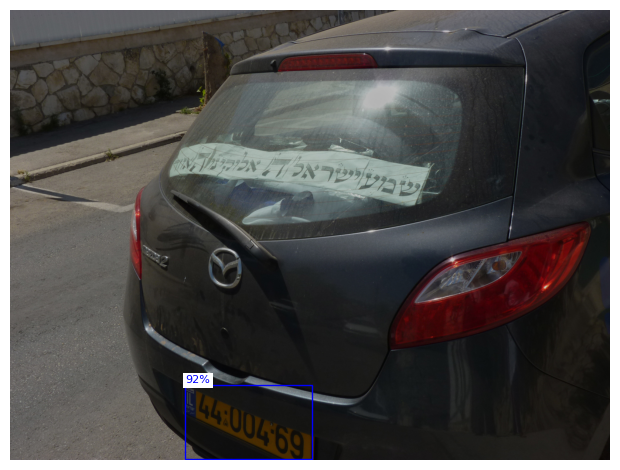

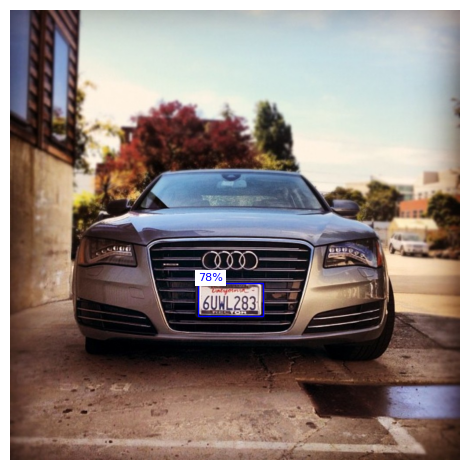

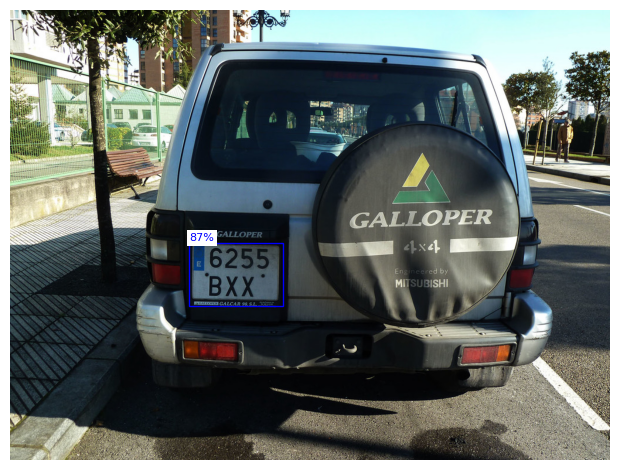

In [11]:
predict_yolo_with_visualizations()

#  <font style="color:green">4. COCO Detection Evaluation [25 Points]</font> 

**You have to evaluate your detection model on COCO detection evaluation metric.**

For your reference here is the coco evaluation metric chart:


---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/03/c3-w9-coco_metric.png">

---

#### <font style="color:red">The expected `AP` (primary challenge metric) is more than `0.5`.</font>

**The expected output should look similar to the following:**

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.886
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.629
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.653
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.704
```



In [12]:
def print_all_coco_metrics(val_results):
    """
    Run pycocotools COCOeval and print all 12 standard COCO metrics.

    Ultralytics only triggers pycocotools automatically for officially-structured
    COCO datasets (is_coco=True). This dataset uses hex-string filenames, so even
    with the COCO layout, image IDs in predictions.json would be strings while
    pycocotools requires integers — COCOeval would score zeros. Instead, we build
    the COCO ground-truth in memory and remap IDs consistently for both GT and
    predictions before running COCOeval.

    Requires model.val() to have been called with save_json=True so that
    predictions.json exists in val_results.save_dir.
    """

    pred_json_path = Path(val_results.save_dir) / 'predictions.json'
    images_dir = Path(config.val_images_folder)
    labels_dir = Path(config.val_labels_folder)

    # Load predictions (image_id is a hex string, e.g. "b01d46f9911d558b")
    with open(pred_json_path, 'r') as f:
        raw_preds = json.load(f)

    if not raw_preds:
        print('\n--- COCO Metrics (pycocotools) ---')
        print('  No predictions found — skipping COCOeval.')
        return

    # pycocotools requires integer IDs. Build a stable str→int mapping from
    # all val images (not just predicted ones, so recall denominator is correct).
    all_stems = sorted(p.stem for p in images_dir.glob('*.jpg'))
    stem_to_id = {stem: i + 1 for i, stem in enumerate(all_stems)}

    # Remap predictions to integer IDs
    remapped_preds = [
        {**pred, 'image_id': stem_to_id[pred['image_id']]}
        for pred in raw_preds
        if pred['image_id'] in stem_to_id
    ]

    # Build COCO ground-truth structure in memory
    coco_images = []
    coco_annotations = []
    ann_id = 1

    for stem in all_stems:
        img = cv2.imread(str(images_dir / f'{stem}.jpg'))
        h, w = img.shape[:2] if img is not None else (640, 640)
        int_id = stem_to_id[stem]

        coco_images.append({'id': int_id, 'file_name': f'{stem}.jpg', 'width': w, 'height': h})

        label_path = labels_dir / f'{stem}.txt'
        if not label_path.exists() or label_path.stat().st_size == 0:
            continue

        with open(label_path) as lf:
            for line in lf:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                _, xc, yc, bw, bh = map(float, parts)
                x = (xc - bw / 2) * w
                y = (yc - bh / 2) * h
                bw_px, bh_px = bw * w, bh * h
                coco_annotations.append({
                    'id': ann_id, 'image_id': int_id, 'category_id': 1,
                    'bbox': [x, y, bw_px, bh_px], 'area': bw_px * bh_px, 'iscrowd': 0,
                })
                ann_id += 1

    # Load into pycocotools without writing any files
    coco_gt = COCO()
    coco_gt.dataset = {
        'images': coco_images,
        'annotations': coco_annotations,
        'categories': [{'id': 1, 'name': 'license_plate', 'supercategory': 'vehicle'}],
    }
    coco_gt.createIndex()
    coco_dt = coco_gt.loadRes(remapped_preds)

    # Run evaluation and print all 12 standard COCO metrics
    print('\n--- COCO Metrics (pycocotools) ---')
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

In [13]:
predict_yolo(return_preds=False, print_coco_metrics=True)

Ultralytics 8.4.14  Python-3.12.12 torch-2.5.1 CPU (AMD Ryzen 7 9800X3D 8-Core Processor)
YOLO26s summary (fused): 122 layers, 9,465,567 parameters, 0 gradients
val: Fast image access  (ping: 0.00.0 ms, read: 2941.4835.1 MB/s, size: 459.4 KB)
val: Scanning C:\Users\Administrator\Documents\MLAI\Open CV University\DLPT\project_4\data\license_plates\labels\val.cache... 386 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 386/386  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 1.3s/it 17.3s1.6s
                   all        386        512      0.909      0.873      0.916      0.697
Speed: 0.4ms preprocess, 38.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Saving C:\Users\Administrator\Documents\MLAI\Open CV University\DLPT\project_4\runs\detect\val9\predictions.json...
Results saved to C:\Users\Administrator\Documents\MLAI\Open CV University\DLPT\project_4\runs\detect\val9
creating index...
index created!
Lo

# <font style="color:green">5. Run Inference on a Video [15 Points]</font>

#### [Download the Input Video](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1)

**You have to run inference on a video.** 

You can download the video from [here](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1).

#### <font style="color:red">Upload the output video on youtube and share the link. Do not upload the video in the lab.</font>

In [ ]:
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("18HWHCevFdU", width=640, height=360)
display(video)

**Your output video should have a bounding box around the vehicle registration plate.**

In [ ]:
video = YouTubeVideo("5SgCuee7AMs", width=640, height=360)
display(video)

**You can use the following sample code to read and write a video.**

In [ ]:
def video_read_write(video_path):
    """
    Read video frames one-by-one, flip it, and write in the other video.
    video_path (str): path/to/video
    """
    video = cv2.VideoCapture(video_path)
    
    # Check if camera opened successfully
    if not video.isOpened(): 
        print("Error opening video file")
        return
    
    # create video writer
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_per_second = video.get(cv2.CAP_PROP_FPS)
    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    output_fname = '{}_out.mp4'.format(os.path.splitext(video_path)[0])
    
    output_file = cv2.VideoWriter(
        filename=output_fname,
        # some installation of opencv may not support x264 (due to its license),
        # you can try other format (e.g. MPEG)
        fourcc=cv2.VideoWriter_fourcc(*"x264"),
        fps=float(frames_per_second),
        frameSize=(width, height),
        isColor=True,
    )
    
        
    i = 0
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            
            output_file.write(frame[:, ::-1, :])
#             cv2.imwrite('anpd_out/frame_{}.png'.format(str(i).zfill(3)), frame[:, ::-1, :])
            i += 1
        else:
            break
        
    video.release()
    output_file.release()
    
    return

In [ ]:
def predict_video():
    model = YOLO(config.saved_weights_filepath)

    video = cv2.VideoCapture(config.video_input_filepath)
    if not video.isOpened():
        print('Error opening video file')
        return

    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video.get(cv2.CAP_PROP_FPS)

    out_dir = os.path.dirname(config.video_output_filepath)
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)
    output_file = cv2.VideoWriter(
        filename=config.video_output_filepath,
        fourcc=cv2.VideoWriter_fourcc(*'mp4v'),
        fps=float(fps),
        frameSize=(width, height),
        isColor=True,
    )

    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break

        results = model.predict(
            source=frame,
            imgsz=config.image_size,
            device=config.device,
            verbose=False,
        )

        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()  # [N, 4] pixel coords (x1, y1, x2, y2)
            confs = result.boxes.conf.cpu().numpy()  # [N]
            for (x1, y1, x2, y2), conf in zip(boxes, confs):
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                cv2.rectangle(frame, (x1, y1), (x2, y2), color=(0, 165, 255), thickness=2)
                label = f'{int(conf * 100)}%'
                cv2.putText(frame, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX,
                            fontScale=0.6, color=(0, 165, 255), thickness=2)

        output_file.write(frame)

    video.release()
    output_file.release()
    print(f'Video saved to: {config.video_output_filepath}')

## My Output Video:

https://youtu.be/fHz9FAlHfBc

In [ ]:
video = YouTubeVideo('fHz9FAlHfBc', width=640, height=360)
display(video)